# Un semplice filtro RC passa-basso

<img src="figs/filtro_RC/RC_filter.png" width="400"/>

Il circuito in alto è descritto dall'equazione di stato

$$
\frac{\mathrm{d}v_{out}}{\mathrm{dt}} = - \frac{v_{out}}{RC} + \frac{v_{in}(t)}{RC}~~,
$$

la cui soluzione può essere scritta come

$$
v_{out}(t) = K e^{-\frac{t}{RC}} + v_{out}^{ip}(t)~~,
$$

dove K è una costante che dipende dalla condizione iniziale e $v_{out}^{ip}(t)$ è l'integrale particolare, che in generale sarà funzione dell'ingresso $v_{in}(t)$.

Consideriamo quindi un ingresso sinusoidale del tipo $v_{in}(t) = E \cos(\omega t + \phi)$: passando al dominio dei fasori abbiamo visto che possiamo scrivere $v_{out}^{ip}(t)$ come

$$
v_{out}^{ip}(t) = \frac{E}{\sqrt{1+\omega^2 R^2 C^2}}\ \cos\left(\omega t + \phi + \theta\right)~~,
$$

dove $\theta = \arctan(-\omega R C)$ è lo sfasamento introdotto dalla presenza del condensatore.

La soluzione complessiva è quindi data da:

$$
v_{out}(t) = \underbrace{\left(v_{out}(0) - \frac{E \cos(\phi + \theta)}{\sqrt{1+\omega^2 R^2 C^2}}\right)\  e^{-\frac{t}{RC}}}_{v_{out}^{rl}(t)} + \underbrace{\frac{E}{\sqrt{1+\omega^2 R^2 C^2}}\ \cos\left(\omega t + \phi + \theta\right)}_{v_{out}^{ip}(t)}~~.
$$

Il termine di risposta libera si smorza con una costante di tempo $\tau = RC$, mentre la risposta forzata sarà tanto più attenuata quanto è elevata la pulsazione $\omega$ del segnale di ingresso.

In questo notebook vedremo come analizzare numericamente il filtro passa-basso mostrato nella figura in alto.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=12)

Definisco innanzitutto le costanti del problema

In [2]:
R = 1e3        # [Ohm]
C = 1e-6       # [F]
E = 1          # [V]
f = 100        # [Hz]
phi = 0        # [1]
w = 2*np.pi*f  # [rad/s]
theta = np.arctan(-w*R*C)
print('La costante di tempo del circuito è tau = {} ms.'.format(R*C*1e3))
print('Il periodo della sinusoide in ingresso è T = {} ms.'.format(1e3/f))

La costante di tempo del circuito è tau = 1.0 ms.
Il periodo della sinusoide in ingresso è T = 10.0 ms.


Definisco gli estremi di integrazione e la condizione iniziale

In [3]:
t_span = [0,10/f]
vout0 = [0]

Calcolo la soluzione esatta dell'equazione di stato

In [4]:
# istanti di tempo equispaziati nell'intervallo t_span
t = np.linspace(t_span[0], t_span[1], 10000)
# la costante K della soluzione
K = vout0[0] - E / np.sqrt(1 + (w*R*C)**2) * np.cos(phi + theta)
# vin(t)
vin = E * np.cos(w*t + phi)
# l'espressione di vout(t)
vout = K * np.exp(-t/(R*C)) + E / np.sqrt(1 + (w*R*C)**2) * np.cos(w*t + phi + theta)

Visualizzo le due forme d'onda

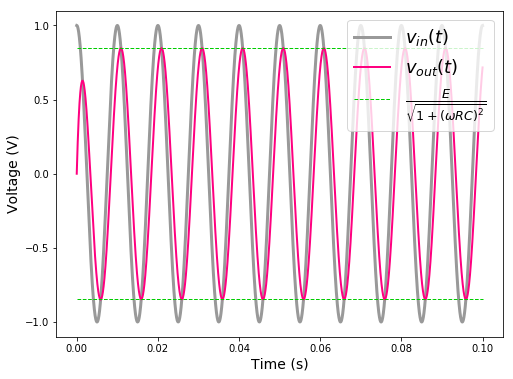

In [5]:
fig,ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(t, vin, color=[.6,.6,.6], lw=3, label=r'$v_{in}(t)$')
ax.plot(t, vout, color=[1, 0, .5], lw=2, label=r'$v_{out}(t)$')
ax.plot(t_span, E/np.sqrt(1+(w*R*C)**2)+np.zeros(2), '--', \
        color=[0,.8,0], lw=1, label=r'$\frac{E}{\sqrt{1+(\omega R C)^2}}$')
ax.plot(t_span, -E/np.sqrt(1+(w*R*C)**2)+np.zeros(2), '--', \
        color=[0,.8,0], lw=1)
ax.legend(loc='upper right', fontsize=18)
ax.set_xlabel('Time (s)', fontsize=14)
ax.set_ylabel('Voltage (V)', fontsize=14)
yticks = np.linspace(-1,1,5)
ax.set_yticks(yticks);

Integriamo ora il sistema usando una funzione per la soluzione numerica di sistemi di equazioni differenziali del primo ordine

In [6]:
# definisce la rhs dell'equazione di stato
def odefun(t, vout, R, C, E, f, phi):
    return (-vout + E * np.cos(2*np.pi*f*t + phi)) / (R*C)

# tolleranze per l'integrazione
atol = 1e-10
rtol = 1e-8

# integro numericamente l'equazione di stato
sol = solve_ivp(lambda t,x: odefun(t,x,R,C,E,f,phi), t_span, vout0, \
                method='BDF', atol=atol, rtol=rtol)

Verifico ora che la soluzione numerica sia uguale a quella analitica

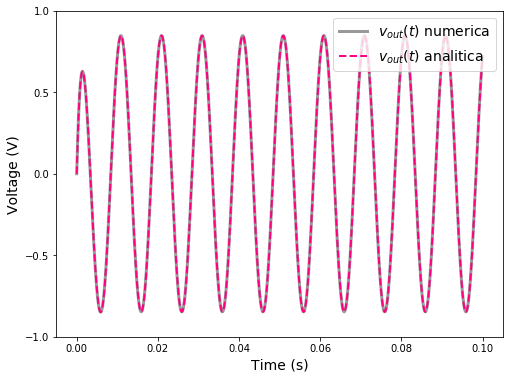

In [7]:
fig,ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(sol['t'], sol['y'][0], color=[.6,.6,.6], lw=3, label=r'$v_{out}(t)$ numerica')
ax.plot(t, vout, '--', color=[1, 0, .5], lw=2, label=r'$v_{out}(t)$ analitica')
ax.legend(loc='upper right', fontsize=14)
ax.set_xlabel('Time (s)', fontsize=14)
ax.set_ylabel('Voltage (V)', fontsize=14)
yticks = np.linspace(-1,1,5)
ax.set_yticks(yticks);

Vediamo ora come varia l'attenuazione di $v_{out}(t)$ al variare della pulsazione $\omega$ di $v_{in}(t)$

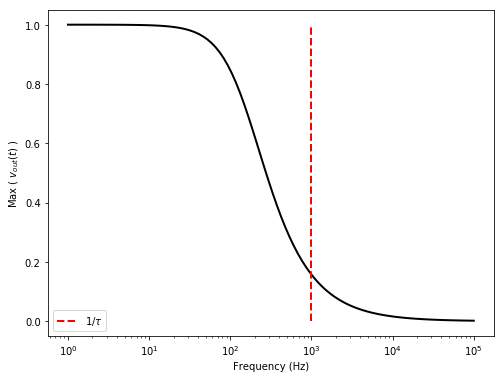

In [8]:
# frequenze da 10^0 a 10^5 equispaziate logaritmicamente
f = np.logspace(0, 5, 100)
# le corrispondenti pulsazione
w = 2*np.pi*f
# l'ampiezza della risposta forzata
amplitude = E / np.sqrt(1 + (w*R*C)**2)
# visualizzo i risultati
fig,ax = plt.subplots(1, 1, figsize=(8,6))
ax.semilogx(f, amplitude, 'k', lw=2)
ax.plot(E/(R*C)+np.zeros(2), [0,1], 'r--', lw=2, label=r'1/$\tau$')
ax.legend(loc='lower left')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'Max ( $v_{out}(t)$ ) ');